In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Reduce dataset

In [ ]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 16

In [ ]:
train_dir = "/content/drive/MyDrive/train"
val_dir = "/content/drive/MyDrive/validation"

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

load dataset

In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1760 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


load efficientNetB0 with pre-trained weights

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


build model

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

train model

In [ ]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    batch_size=BATCH_SIZE
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 1259s 11s/step - accuracy: 0.4961 - loss: 0.7092 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 654ms/step - accuracy: 0.5071 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 652ms/step - accuracy: 0.5117 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 653ms/step - accuracy: 0.4974 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 645ms/step - accuracy: 0.5109 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6932


unfreeze last few layers and fine-tune

In [25]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    batch_size=BATCH_SIZE
)

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 107s 797ms/step - accuracy: 0.5069 - loss: 0.7096 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 742ms/step - accuracy: 0.4765 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.6975
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 742ms/step - accuracy: 0.4823 - loss: 0.6987 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 742ms/step - accuracy: 0.4775 - loss: 0.6965 - val_accuracy: 0.5750 - val_loss: 0.6932
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 726ms/step - accuracy: 0.4892 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6931


Save model

In [28]:
model.save("dog_vs_cat_classifier.h5")

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def show_predictions(model, generator, num_images=5):
    images, labels = next(generator)
    preds = model.predict(images)
    for i in range(num_images):
        plt.imshow(images[i])
        plt.title(f"Predicted: {'Dog' if preds[i] > 0.5 else 'Cat'} | Actual: {'Dog' if labels[i] > 0.5 else 'Cat'}")
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


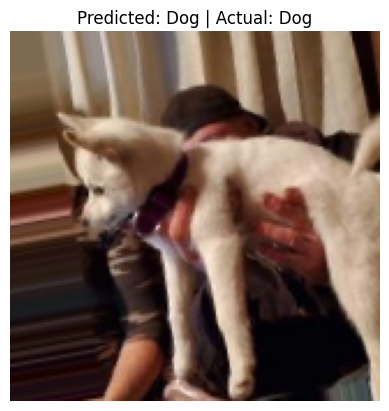

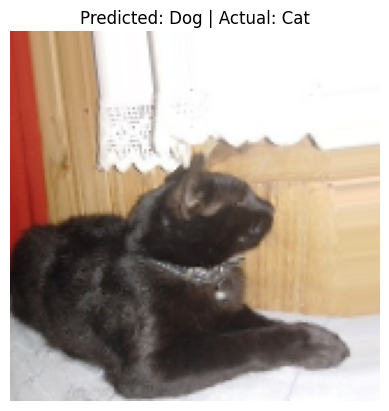

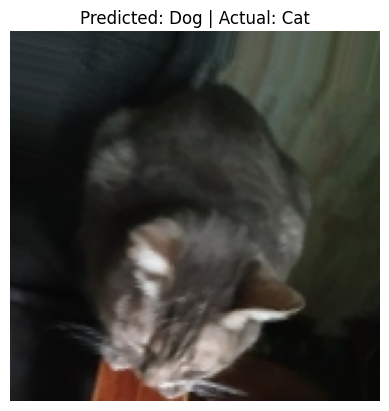

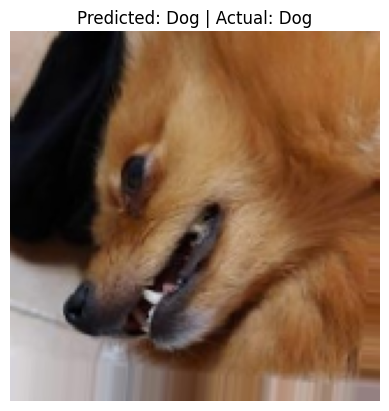

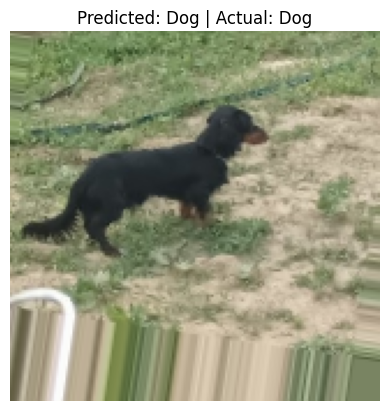

In [31]:
show_predictions(model, val_generator)

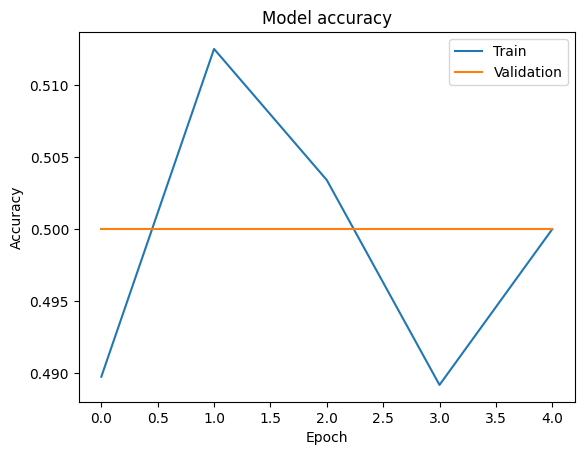

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()